### GRU RNN Implementation

In this notebook we will implement a GRU RNN in order to forecast the AQI with all of the available meteorological data at the Chicago SH Bell monitoring site.

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator
from google.cloud import storage

Using TensorFlow backend.


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


#### Making Train/Test Splits

In [4]:
aqi_df = pd.read_csv('./data/SH_Bell/combined_meteor_and_sample.csv', index_col='Unnamed: 0', parse_dates=True)
# aqi_df['Hour'] = aqi_df.index.hour
aqi_df_12h = aqi_df.resample('12h').mean()

In [5]:
aqi_df.head()

,AWS Mph WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,AWD_cos,AWD_sin,Sample Value
2017-04-01 00:00:00,5.989,15.55,38.74,29.41,0.998027,-0.062791,4.0
2017-04-01 01:00:00,5.059,11.30,39.46,29.44,0.978148,-0.207912,6.0
2017-04-01 02:00:00,5.390,11.30,39.08,29.45,0.999925,-0.012217,7.0
2017-04-01 03:00:00,5.233,11.59,38.95,29.47,0.991671,-0.128796,6.0
2017-04-01 04:00:00,3.614,8.68,38.86,29.49,0.841511,-0.540240,8.0


In [45]:
target_names = ['Sample Value']
shift_days = 1
shift_steps = shift_days*12 # Number of hours
aqi_df_targets = aqi_df[target_names].shift(-shift_steps)

In [61]:
aqi_df.head(24)

,AWS Mph WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,AWD_cos,AWD_sin,Sample Value
2017-04-01 00:00:00,5.989,15.550,38.74,29.41,0.998027,-0.062791,4.0
2017-04-01 01:00:00,5.059,11.300,39.46,29.44,0.978148,-0.207912,6.0
2017-04-01 02:00:00,5.390,11.300,39.08,29.45,0.999925,-0.012217,7.0
2017-04-01 03:00:00,5.233,11.590,38.95,29.47,0.991671,-0.128796,6.0
2017-04-01 04:00:00,3.614,8.680,38.86,29.49,0.841511,-0.540240,8.0
2017-04-01 05:00:00,2.051,4.716,36.87,29.49,0.623880,-0.781520,11.0
2017-04-01 06:00:00,2.134,4.190,35.21,29.51,0.135716,-0.990748,16.0
2017-04-01 07:00:00,2.335,5.277,36.02,29.55,0.361625,-0.932324,20.0
2017-04-01 08:00:00,3.432,9.590,40.24,29.57,0.949425,-0.313992,16.0
2017-04-01 09:00:00,4.208,7.870,43.56,29.58,0.995803,0.091519,7.0


#### Scaling the Data

In [70]:
def log_trans(y):
    y = np.array(y)
    return np.log10(y + 1)

def inv_log_trans(y):
    y = np.array(y)
    return 10**y - 1

def preprocesser(df, target_names, shift_steps, train_ratio, scale_idx_list):
    """
    Takes in the aqi_df and returns processed versions of the train and test splits.
    The number of shift steps, the train_ratio, and the variables that will be min-max
    scaled can be adjusted.
    The min-max scaler for the target is also returned so that it can be used later to invert
    the predictions and compare to the true values.
    """
    df = df.copy()
    
#     df[target_names] = log_trans(df[target_names])
    df_targets = df[target_names].shift(-shift_steps)
    
    X_data = df.values[0:-shift_steps]
    y_data = df_targets.values[:-shift_steps]

    num_data = len(X_data)
    num_train = int(train_ratio * num_data)
    num_test = num_data - num_train
    X_train = X_data[0:num_train]
    X_test = X_data[num_train:]
    y_train = y_data[0:num_train]
    y_test = y_data[num_train:]
    
    X_scaler = MinMaxScaler()
    X_train[:, scale_idx_list] = X_scaler.fit_transform(X_train[:, scale_idx_list])
    X_test[:, scale_idx_list] = X_scaler.transform(X_test[:, scale_idx_list])

    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)
    
    return X_train, y_train, X_test, y_test, y_scaler

def inv_y(y_scaled, y_scaler):
    y_log = y_scaler.inverse_transform(y_scaled)
    return inv_log_trans(y_log)

In [71]:
X_train, y_train, X_test, y_test, y_scaler = preprocesser(aqi_df, target_names, shift_steps, 0.80, [0,1,2,3,6])

In [72]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(y_true=y_true_slice,
                                        y_pred=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [73]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, X_test.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, y_test.shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(X_train.shape[0] - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X_train[idx:idx+sequence_length]
            y_batch[i] = y_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [74]:
validation_data = (np.expand_dims(X_test, axis=0),
                  np.expand_dims(y_test, axis=0))

#### Building the GRU

In [88]:
model = Sequential()
model.add(GRU(units=64,
              return_sequences=True,
              input_shape=(None, X_test.shape[1],)
             ))
model.add(Dropout(0.2))
model.add(GRU(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(y_test.shape[1], activation='sigmoid'))

In [89]:
optimizer = RMSprop(0.01)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [90]:
batch_size = 128
sequence_length = 24*7*4 # 4 week long sequences
gru_generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

model.fit_generator(generator=gru_generator, 
                    epochs=15,
                    verbose=1, steps_per_epoch=2,
                    validation_data=validation_data,
                    use_multiprocessing=True)

Epoch 1/15
2/2 [==============================] - 29s 14s/step - loss: 0.0837 - val_loss: 0.0021
Epoch 2/15
2/2 [==============================] - 19s 9s/step - loss: 0.0031 - val_loss: 0.0020
Epoch 3/15
2/2 [==============================] - 19s 9s/step - loss: 0.0030 - val_loss: 0.0021
Epoch 4/15
2/2 [==============================] - 19s 10s/step - loss: 0.0036 - val_loss: 0.0022
Epoch 5/15
2/2 [==============================] - 20s 10s/step - loss: 0.0031 - val_loss: 0.0020
Epoch 6/15
2/2 [==============================] - 20s 10s/step - loss: 0.0029 - val_loss: 0.0020
Epoch 7/15
2/2 [==============================] - 19s 9s/step - loss: 0.0033 - val_loss: 0.0025
Epoch 8/15
2/2 [==============================] - 19s 9s/step - loss: 0.0035 - val_loss: 0.0019
Epoch 9/15
2/2 [==============================] - 19s 9s/step - loss: 0.0031 - val_loss: 0.0019
Epoch 10/15
2/2 [==============================] - 18s 9s/step - loss: 0.0033 - val_loss: 0.0019
Epoch 11/15
2/2 [==================

In [54]:
from keras.models import load_model

model = load_model('./models/chicago_gru_12h_16d_512batch.hf5', compile=False)
optimizer = RMSprop(0.01)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [91]:
result = model.evaluate(x=np.expand_dims(X_test, axis=0),
                        y=np.expand_dims(y_test, axis=0))

1/1 [==============================] - 2s 2s/step


In [97]:
def plot_comparison(start_idx, length=100, train=False):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_train
        y_true = y_train
    else:
        # Use test-data.
        x = X_test
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]

    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    
    # For each output-signal.
    for signal in range(len(target_names)):

        signal_pred = y_pred[:, signal]
        signal_true = y_true[:, signal]
        plt.figure(figsize=(15,5))
        plt.plot(signal_true, label='True Values')
        plt.plot(signal_pred, label='Predicted Values')
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        plt.ylabel(r'$PM_{10}$ Concentration')
        plt.xlabel('Sample Hour')
        plt.title('Concentration Predictions vs True Values')
        plt.legend()
        plt.show()

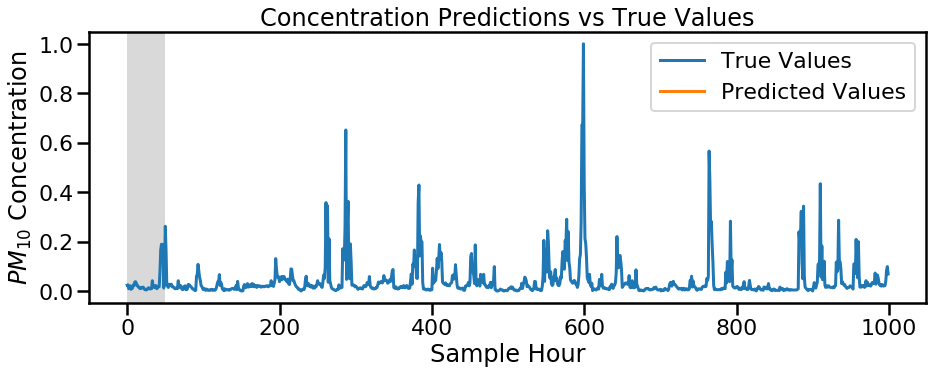

In [99]:
sns.set_context('poster')
plot_comparison(start_idx=0, length=1000, train=True)

In [86]:
y_pred.shape

(390, 1)

(0.9166666666666665, 96.41666666666669)

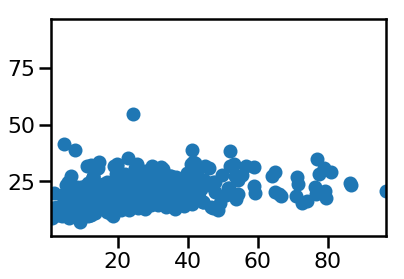

In [94]:
plt.scatter(y_true, y_pred)
plt.xlim(y_true.min(), y_true.max())
plt.ylim(y_true.min(), y_true.max())

In [162]:
model.save('./chicago_gru_12h_16d_512batch.hf5')